In [1]:
import rawpy
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import importlib
import find_stars
importlib.reload(find_stars)
from find_stars import StarFinder

In [3]:
out_of_focus = r"C:\code\astrocam\outoffocus\Image741.nef"
in_focus = r"C:\code\astrocam\light\Image752.nef"

s = StarFinder()

ref_data = s.getStarData(in_focus)
tgt_data = s.getStarData(out_of_focus)
ref_image, ref_stars = ref_data["image"], ref_data["stars"]
tgt_image, tgt_stars = tgt_data["image"], tgt_data["stars"]


In [4]:
def getStarDF(stardata):
  df = pd.DataFrame(stardata)
  df.drop(0, axis=0, inplace=True)
  return df


In [5]:
df_ref = getStarDF(ref_stars)

In [6]:
df_ref

,area,centroid,box,tile_4,tile_16,tile_32
1,43,"[560.8372093023256, 1.9069767441860466]","[556, 0, 566, 5]",140,35,18
2,88,"[2968.9204545454545, 180.60227272727272]","[2964, 175, 2974, 186]",49252,3156,903
3,70,"[2920.4, 182.1]","[2916, 177, 2925, 187]",50318,3153,901
4,206,"[2233.9854368932038, 241.9126213592233]","[2226, 233, 2242, 251]",65238,4190,1150
5,49,"[679.0, 495.0]","[675, 491, 683, 499]",133842,8412,2046
6,151,"[1154.4370860927152, 579.5165562913908]","[1148, 572, 1161, 587]",156599,9792,2466
7,49,"[2172.0, 793.0]","[2168, 789, 2176, 797]",213987,13636,3443
8,56,"[1510.0, 864.5]","[1506, 860, 1514, 869]",233226,14674,3692
9,177,"[1913.9943502824858, 933.6836158192091]","[1907, 926, 1921, 942]",251652,15780,3975
10,63,"[2265.5555555555557, 951.4444444444445]","[2261, 947, 2270, 956]",257130,16072,4121


In [7]:
df_tgt = getStarDF(tgt_stars)

In [8]:
from itertools import combinations, product
import math

def star_dist(s1, s2):
    x1,y1 = s1.centroid
    x2,y2 = s2.centroid
    d = math.sqrt((x2-x1)**2 + (y2-y1)**2)
    return d

def getTriangles(df):
    starDistances = {}
    cc = list(combinations(df.index, 2))
    for c in cc:
        assert(c[1] > c[0])
        key = (c[0], c[1])
        starDistances[key] = star_dist(df.loc[c[0]], df.loc[c[1]])

    #starDistances = pd.DataFrame({"pair":tuple(sorted([c[0], c[1]])), "dist": dist_fn(df.loc[c[0]], df.loc[c[1]])} for c in cc).sort_values('dist')
    num_stars = len(df)

    vTriangles = []
    for i in range(1, num_stars+1):
        for j in range(i+1, num_stars+1):
            for k in range(j+1, num_stars+1):
                vDistances = sorted([starDistances[(i,j)], starDistances[(j,k)], starDistances[(i,k)]])

                if vDistances[2] > 0:
                    fX = vDistances[1]/vDistances[2]
                    fY = vDistances[0]/vDistances[2]

                    # Filter
                    if (fX < 0.9):
                        # Add to the triangle list
                        vTriangles.append({"s1":i, "s2":j, "s3":k, "fX":fX, "fY":fY})

    vTriangles = sorted(vTriangles, key=lambda x: x["fX"])
    return pd.DataFrame(vTriangles)


In [18]:
tri_ref = getTriangles(df_ref)
print(len(tri_ref))

5993


In [19]:
tri_tgt = getTriangles(df_tgt)
print(len(tri_tgt))

7386


In [11]:
itLastUsedRef = 0
TRIANGLETOLERANCE = 1e-4
votes = np.zeros((len(df_ref)+1, len(df_tgt)+1), dtype=np.uint32)
for tgt in tri_tgt.itertuples():

    while itLastUsedRef != len(tri_ref) and \
        tgt.fX > tri_ref.iloc[itLastUsedRef].fX + TRIANGLETOLERANCE:
            itLastUsedRef += 1

    if itLastUsedRef == len(tri_ref):
        break

    itRef = itLastUsedRef
    while itRef != len(tri_ref) and tri_ref.iloc[itRef].fX < tgt.fX + TRIANGLETOLERANCE:
        ref = tri_ref.iloc[itRef]
        x1,y1 = ref.fX, ref.fY
        x2,y2 = tgt.fX, tgt.fY
        d = math.sqrt((x2-x1)**2 + (y2-y1)**2)
        if d < TRIANGLETOLERANCE:
            for a,b in product([ref.s1, ref.s2, ref.s3], [tgt.s1, tgt.s2, tgt.s3]):
                votes[int(a), b] += 1
        itRef += 1


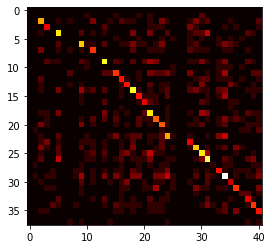

In [12]:
plt.imshow(votes, cmap='hot')
plt.show()

In [13]:
vVotingPairs = np.column_stack(np.unravel_index(np.argsort(votes, axis=None), shape=votes.shape))[::-1]

In [14]:
len(vVotingPairs)

1558

In [15]:
x,y = vVotingPairs[len(df_tgt)*2-1]
cutoff = min(1,votes[x,y])
idx = 0
while idx < vVotingPairs.shape[0]:
    x,y = vVotingPairs[idx]
    val = votes[x,y]
    if val <= cutoff:
        break
    idx += 1

topVotePairs = vVotingPairs[:idx]

In [16]:
len(topVotePairs)

178

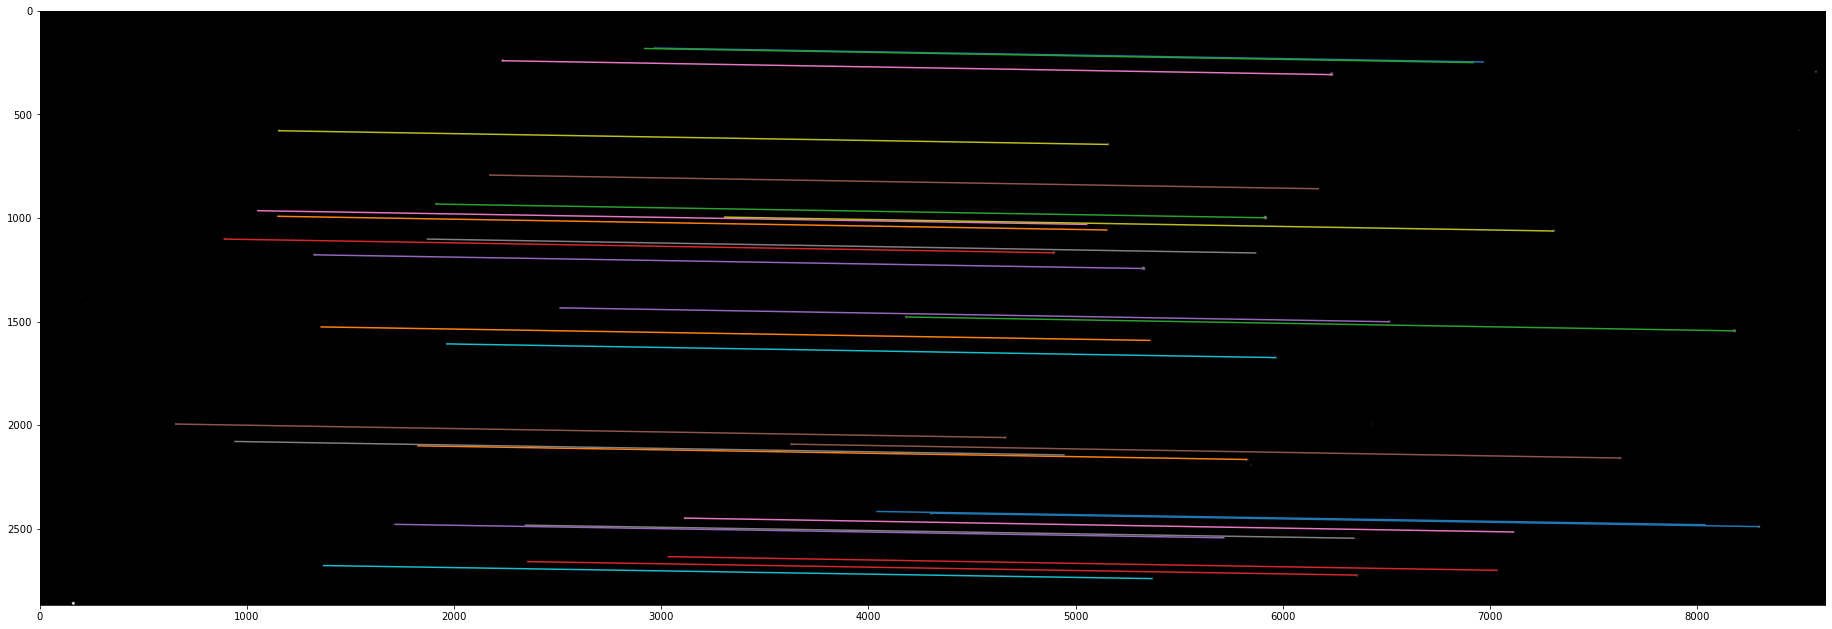

In [17]:
img = np.column_stack((ref_image,tgt_image))
fig = plt.figure(figsize=(32,16))
plt.imshow(img, cmap='gray')

for vp in topVotePairs:
    s1, s2 = vp

    if np.argmax(votes[:, s2]) != s1 or np.argmax(votes[s1, :]) != s2:
        continue

    x1,y1 = df_ref.loc[s1].centroid
    x2,y2 = df_tgt.loc[s2].centroid
    x2 += ref_image.shape[1]
    xs = [int(x1), int(x2)]
    ys = [int(y1), int(y2)]
    plt.plot(xs, ys)

plt.show()